In [1]:
!pip install roboflow

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="4Sl2Sr0z84e1LF6aiMEP")
project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
version = project.version(1)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...


In [3]:
# Paths
dataset_path = "/Traffic-and-Road-Signs-1"  # Update with your dataset path
image_size = (64, 64)  # Resize for CNN
classes = [
    "Road narrows on right","50 mph speed limit","Attention Please",
    "Beware of children","CYCLE ROUTE AHEAD WARNING", "Dangerous Left Curve Ahead", "Dangerous Right Curve Ahead",
    "End of all speed and passing limits", "Give Way","Go Straight or Turn Right","Go straight or turn left",
    "Keep-Left","Keep-Right","Left Zig Zag Traffic","No Entry","No_Over_Taking",
    "Overtaking by trucks is prohibited", "Pedestrian Crossing","Round-About","Slippery Road Ahead",
    "Speed Limit 20 KMPh","Speed Limit 30 KMPh","Stop_Sign", "Straight Ahead Only","Traffic_signal",
    "Truck traffic is prohibited", "Turn left ahead","Turn right ahead","Uneven Road"
]

num_classes = len(classes)
class_mapping = {i: cls for i, cls in enumerate(classes)}

In [4]:
import os
import numpy as np
import cv2
def parse_yolo_labels(base_path, img_size):
    images = []
    labels = []

    for split in ['train', 'valid', 'test']:
        images_path = os.path.join(base_path, split, "images")
        labels_path = os.path.join(base_path, split, "labels")

        for label_file in os.listdir(labels_path):
            label_path = os.path.join(labels_path, label_file)
            img_file = label_file.replace(".txt", ".jpg")
            img_path = os.path.join(images_path, img_file)

            # Check if corresponding image exists
            if not os.path.exists(img_path):
                print(f"Image file not found: {img_path}")
                continue

            # Read label file
            with open(label_path, "r") as f:
                lines = f.readlines()
                if not lines:
                    print(f"Empty label file: {label_path}")
                    continue  # Skip empty files

                # Process each line in the label file
                valid_labels = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) != 5:  # YOLO format: class_id, x_center, y_center, width, height
                        print(f"Incomplete label in file {label_path}: {line.strip()}")
                        continue
                    try:
                        class_id = int(parts[0])
                        valid_labels.append(class_id)
                    except ValueError:
                        print(f"Invalid class ID in file {label_path}: {line.strip()}")
                        continue

                # Add first valid label (if any) to the dataset
                if valid_labels:
                    labels.append(valid_labels[0])  # Use only the first label for simplicity

            # Read and preprocess the image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Unable to load image: {img_path}")
                continue
            image = cv2.resize(image, img_size)
            images.append(image)

    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    return np.array(images), np.array(labels)

# Dataset paths
dataset_path = "Traffic-and-Road-Signs-1"
image_size = (64, 64)

# Load data
X, y = parse_yolo_labels(dataset_path, image_size)


Loaded 10000 images and 10000 labels.


In [5]:
import numpy as np

num_classes = len(np.unique(y))  # Count unique labels
print("Unique labels in dataset:", np.unique(y))
print("Number of classes:", num_classes)


Unique labels in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Number of classes: 29


In [6]:
X.shape

(10000, 64, 64, 3)

In [7]:
# Normalize images
X = X / 255.0

In [8]:
from tensorflow.keras.utils import to_categorical
# One-hot encode labels
y = to_categorical(y, num_classes=num_classes)

In [10]:
from sklearn.model_selection import train_test_split
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Define Custom CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
# Create Model
model = create_cnn_model((image_size[0], image_size[1], 3), num_classes)

In [16]:
# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Adjust epochs as needed
    batch_size=32
)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4562 - loss: 1.9567 - val_accuracy: 0.9455 - val_loss: 0.2602
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9610 - loss: 0.1815 - val_accuracy: 0.9595 - val_loss: 0.1781
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9807 - loss: 0.0798 - val_accuracy: 0.9625 - val_loss: 0.1987
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9919 - loss: 0.0406 - val_accuracy: 0.9670 - val_loss: 0.1526
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9930 - loss: 0.0264 - val_accuracy: 0.9620 - val_loss: 0.1787
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9848 - loss: 0.0619 - val_accuracy: 0.9815 - val_loss: 0.1288
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.9875 - val_loss: 0.1116
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9991 - loss: 0.004

In [17]:
# Save Model
model.save("CUSTOMCNNMODELJOSH.h5")

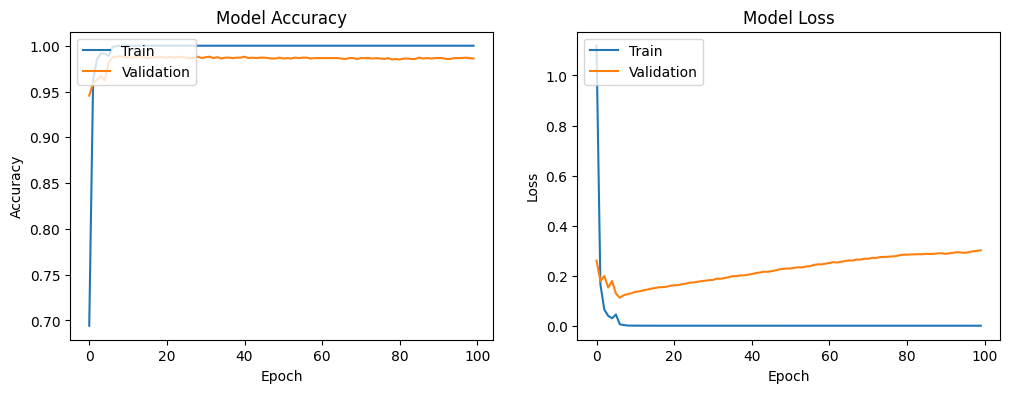

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot the training history
plot_training_history(history)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


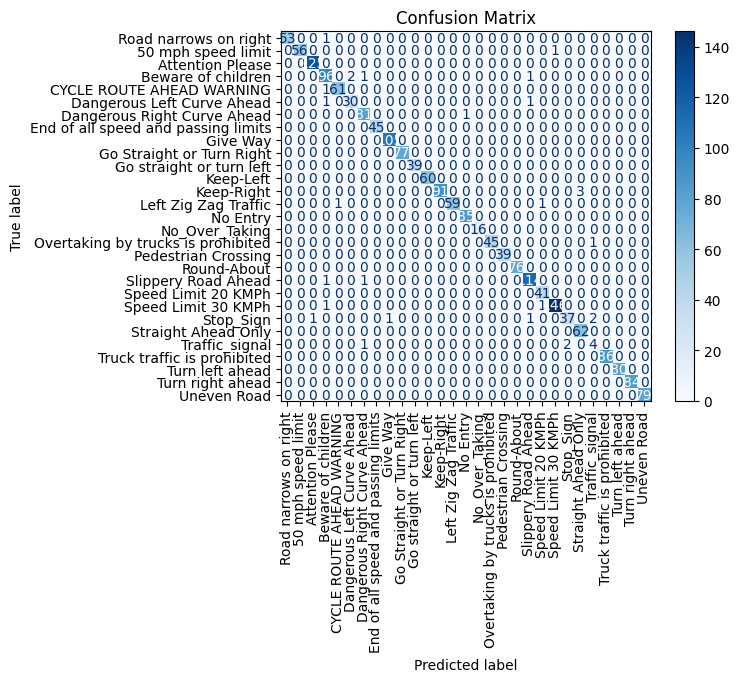

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, X_test, y_test, classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation='vertical', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set
plot_confusion_matrix(model, X_val, y_val, classes)


In [20]:
from sklearn.metrics import classification_report

def print_classification_report(model, X_test, y_test, classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
    print("Classification Report:\n", report)

# Print classification report
print_classification_report(model, X_val, y_val, classes)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
                                      precision    recall  f1-score   support

              Road narrows on right       1.00      0.98      0.99        54
                 50 mph speed limit       1.00      0.98      0.99        57
                   Attention Please       0.99      1.00      1.00       125
                 Beware of children       0.95      0.96      0.96       100
          CYCLE ROUTE AHEAD WARNING       0.98      0.98      0.98        62
         Dangerous Left Curve Ahead       0.94      0.94      0.94        32
        Dangerous Right Curve Ahead       0.96      0.99      0.98        82
End of all speed and passing limits       1.00      1.00      1.00        45
                           Give Way       0.99      1.00      1.00       105
          Go Straight or Turn Right       1.00      1.00      1.00        77
           Go straight or turn left       1.00      1.00      1.00        39
            

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


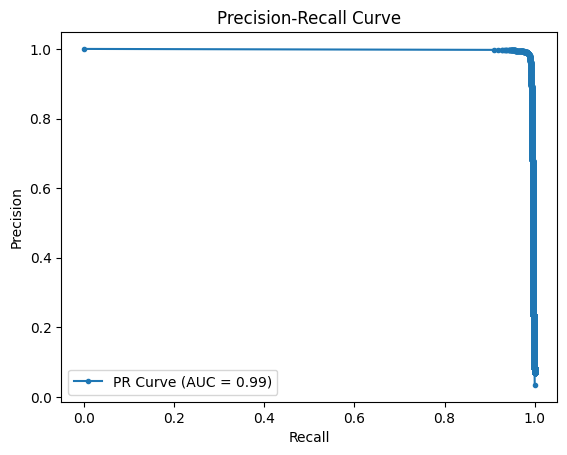

In [21]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_flat = y_test.ravel()
    y_pred_flat = y_pred.ravel()

    precision, recall, _ = precision_recall_curve(y_test_flat, y_pred_flat)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_precision_recall_curve(model, X_val, y_val)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


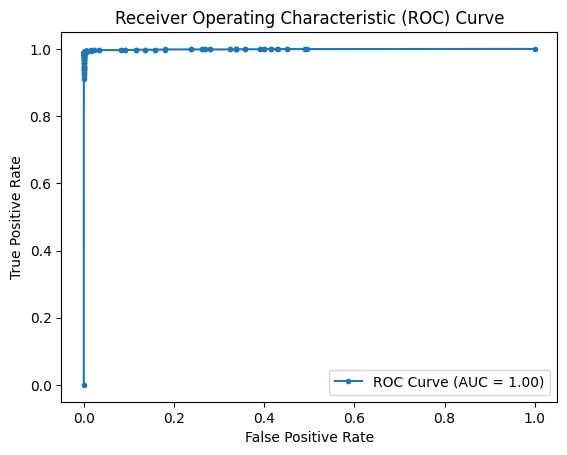

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_flat = y_test.ravel()
    y_pred_flat = y_pred.ravel()

    fpr, tpr, _ = roc_curve(y_test_flat, y_pred_flat)
    auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')

    plt.figure()
    plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(model, X_val, y_val)


In [24]:
def misclassification_analysis(model, X_test, y_test, classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

    print(f"Number of misclassified samples: {len(misclassified_indices)}")
    for i in misclassified_indices[:5]:  # Display first 5 misclassified examples
        print(f"True label: {classes[y_true_classes[i]]}, Predicted: {classes[y_pred_classes[i]]}")

misclassification_analysis(model, X_val, y_val, classes)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Number of misclassified samples: 28
True label: Beware of children, Predicted: Slippery Road Ahead
True label: Slippery Road Ahead, Predicted: Beware of children
True label: Speed Limit 30 KMPh, Predicted: Speed Limit 20 KMPh
True label: Dangerous Left Curve Ahead, Predicted: Beware of children
True label: 50 mph speed limit, Predicted: Speed Limit 30 KMPh


In [ ]:
import os
import random
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

# Load the trained model
model_path = "CUSTOMCNNMODELJOSH.h5"
model = load_model(model_path)

# Class labels
classes = [
    "Road narrows on right","50 mph speed limit","Attention Please",
    "Beware of children","CYCLE ROUTE AHEAD WARNING", "Dangerous Left Curve Ahead", "Dangerous Right Curve Ahead",
    "End of all speed and passing limits", "Give Way","Go Straight or Turn Right","Go straight or turn left",
    "Keep-Left","Keep-Right","Left Zig Zag Traffic","No Entry","No_Over_Taking",
    "Overtaking by trucks is prohibited", "Pedestrian Crossing","Round-About","Slippery Road Ahead",
    "Speed Limit 20 KMPh","Speed Limit 30 KMPh","Stop_Sign", "Straight Ahead Only","Traffic_signal",
    "Truck traffic is prohibited", "Turn left ahead","Turn right ahead","Uneven Road"
]
# Image preprocessing function
def preprocess_image(image, target_size=(64, 64)):
    """
    Resize and normalize the image for prediction.
    """
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to test on multiple images
def test_on_multiple_images(test_images_path, test_labels_path, num_samples=5):
    """
    Test the model on multiple images from the test dataset.
    """
    image_files = os.listdir(test_images_path)
    random.shuffle(image_files)  # Shuffle the dataset
    selected_files = image_files[:num_samples]

    for file in selected_files:
        # Load the image
        img_path = os.path.join(test_images_path, file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Unable to load image {img_path}")
            continue

        # Preprocess the image
        input_image = preprocess_image(image)

        # Predict the road sign
        predictions = model.predict(input_image)
        predicted_class_index = np.argmax(predictions)
        predicted_class = classes[predicted_class_index]

        # Load the ground truth label
        label_file = file.replace(".jpg", ".txt").replace(".png", ".txt")
        label_path = os.path.join(test_labels_path, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if lines:
                ground_truth_index = int(lines[0].split()[0])
                ground_truth_class = classes[ground_truth_index]
            else:
                ground_truth_class = "Unknown"

        # Display the image with predictions
        cv2.putText(image, f"Predicted: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(image, f"Actual: {ground_truth_class}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        cv2_imshow( image)

        # Wait for key press to proceed to the next image
        print(f"Image: {file}, Predicted: {predicted_class}, Actual: {ground_truth_class}")
        cv2.waitKey(0)

    cv2.destroyAllWindows()

# Paths
test_images_path = "/content/Traffic-and-Road-Signs-1/test/images"
test_labels_path = "/content/Traffic-and-Road-Signs-1/test/labels"

# Test the function
test_on_multiple_images(test_images_path, test_labels_path, num_samples=5)
# 306

ModuleNotFoundError: No module named 'google.colab'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


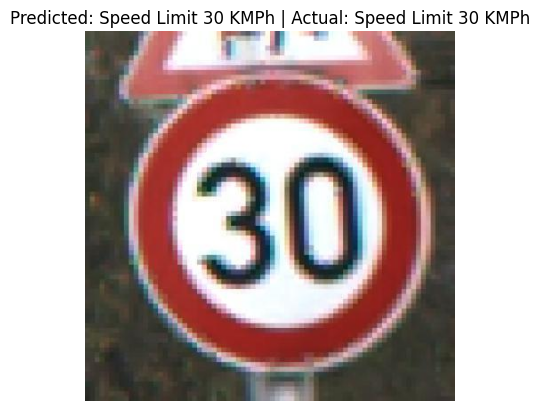

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


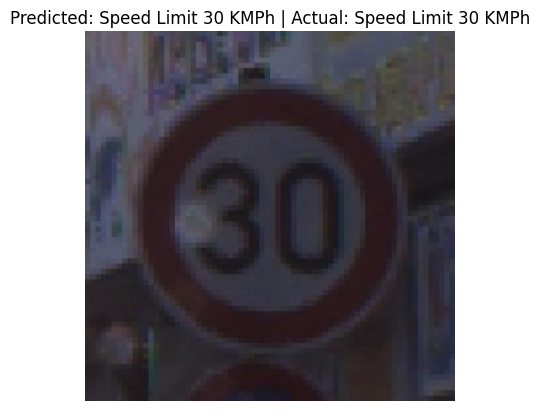

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


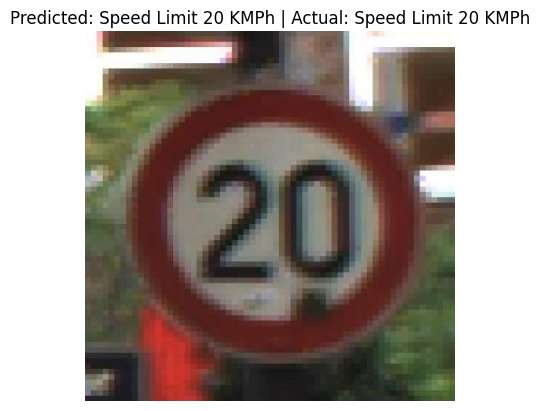

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


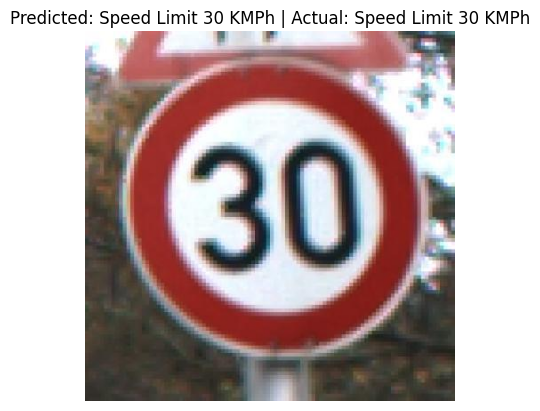

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


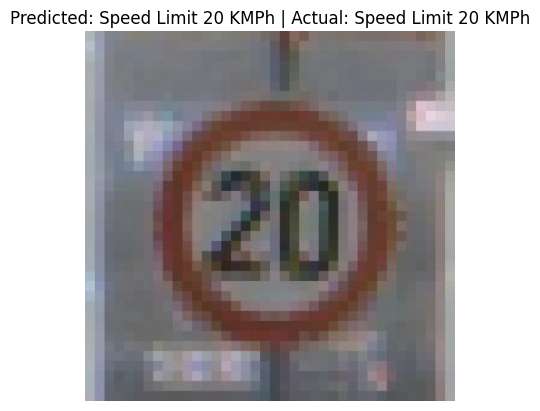

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


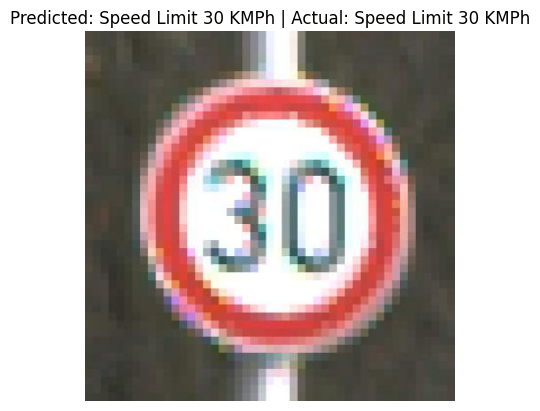

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


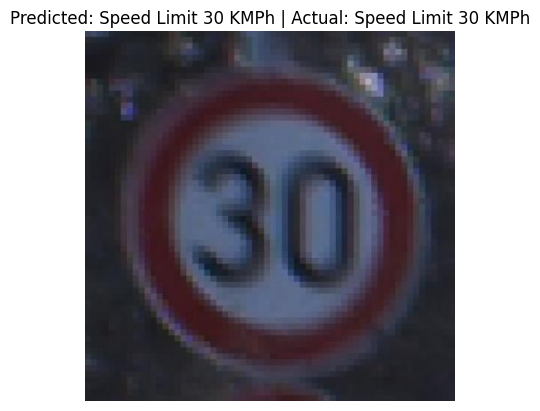

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


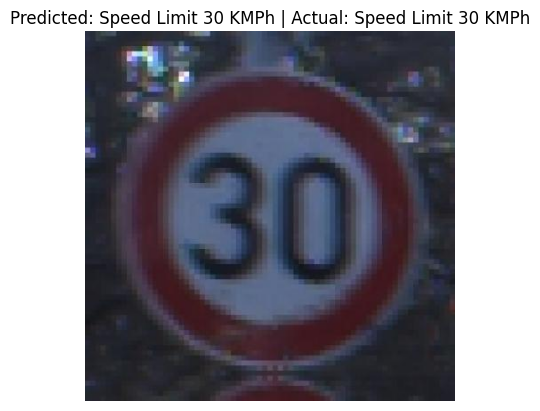

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


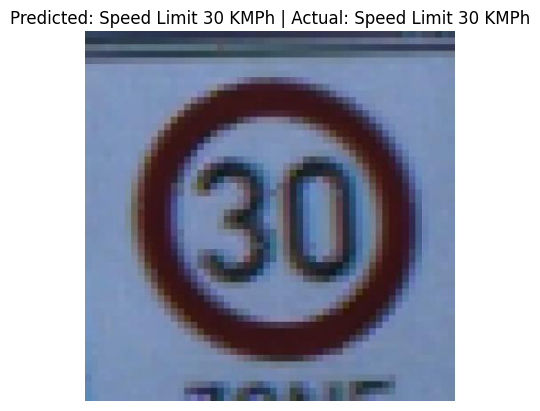

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


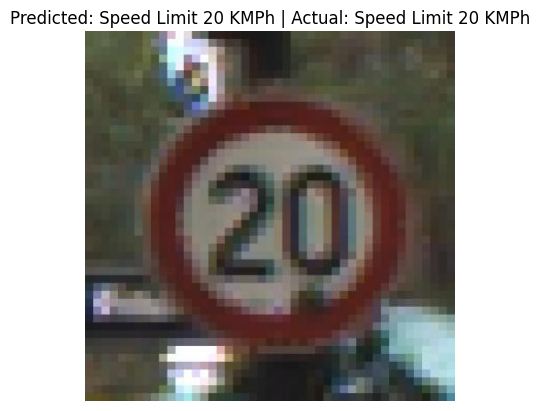

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


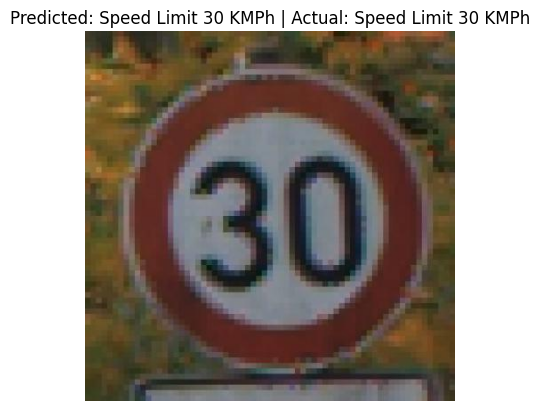

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


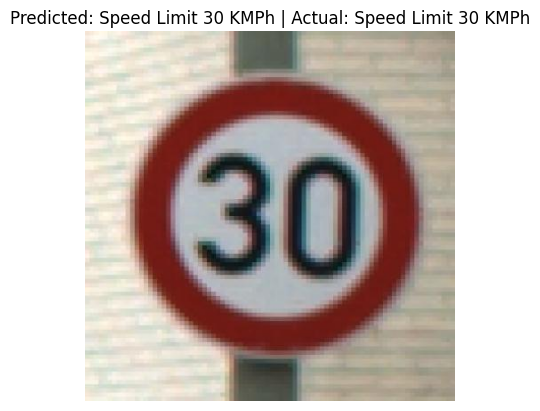

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


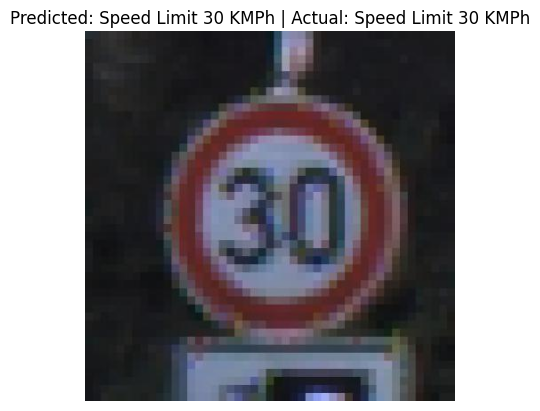

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


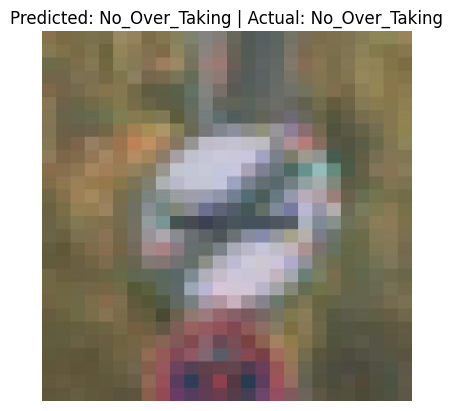

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


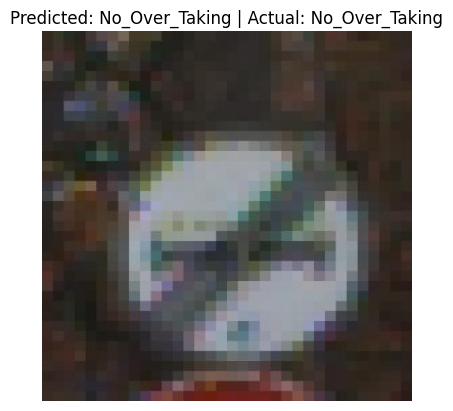

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


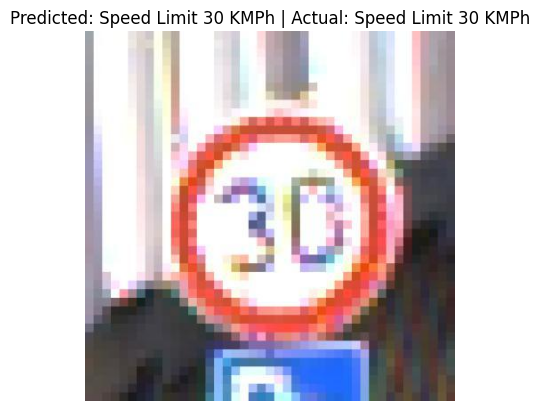

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


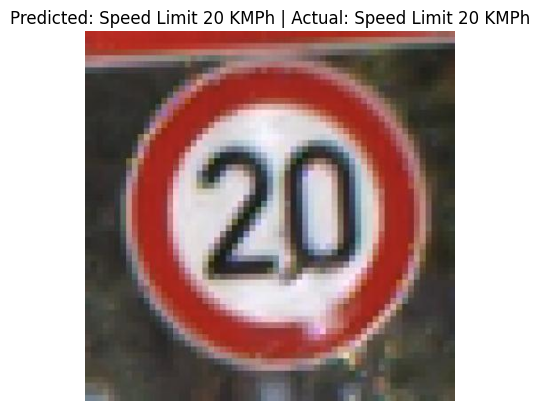

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


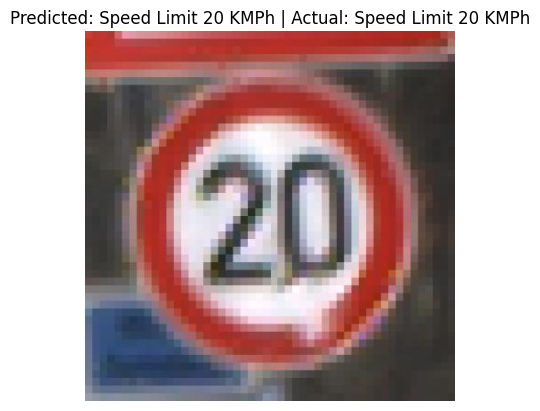

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


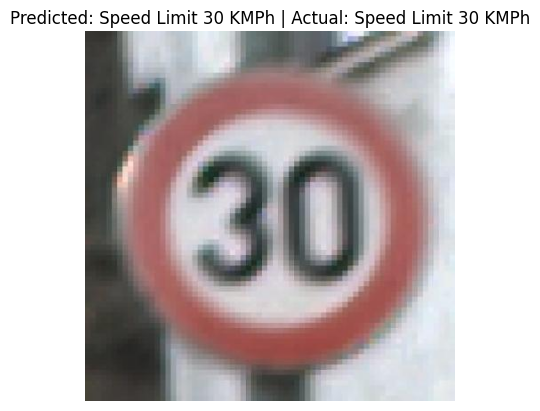

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


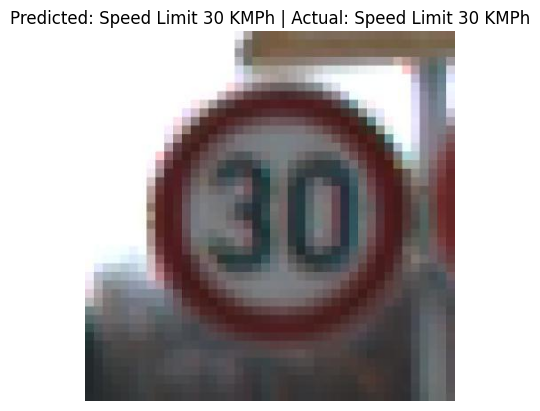

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


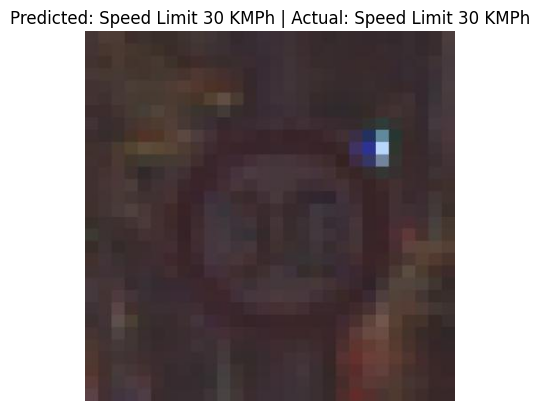

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


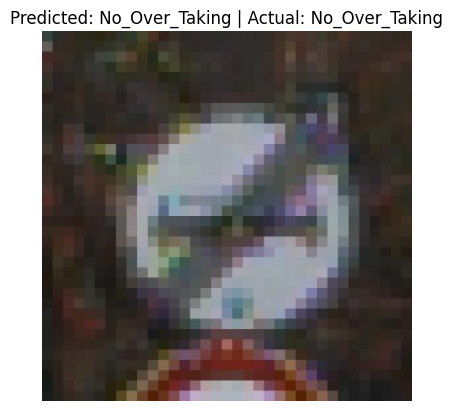

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


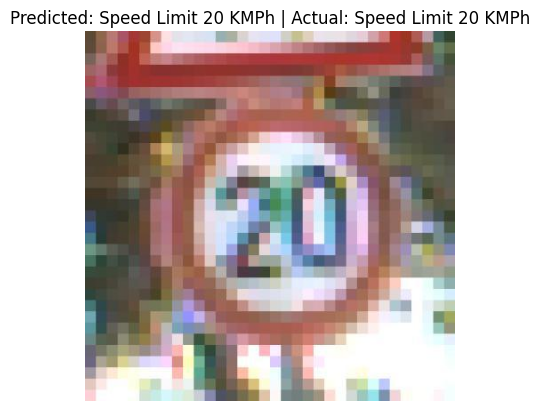

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


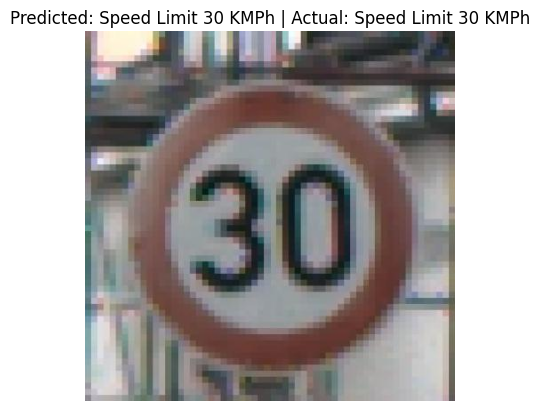

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


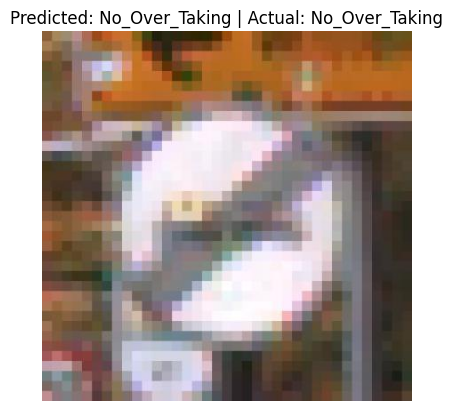

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


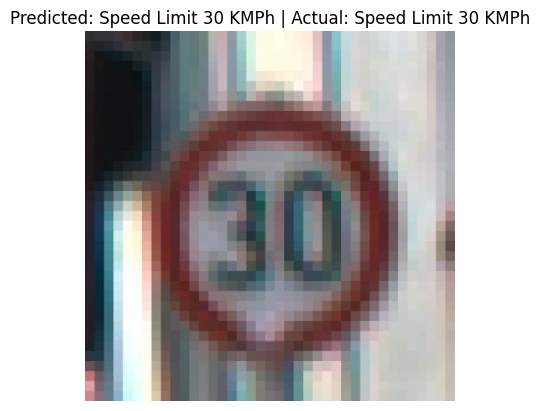

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


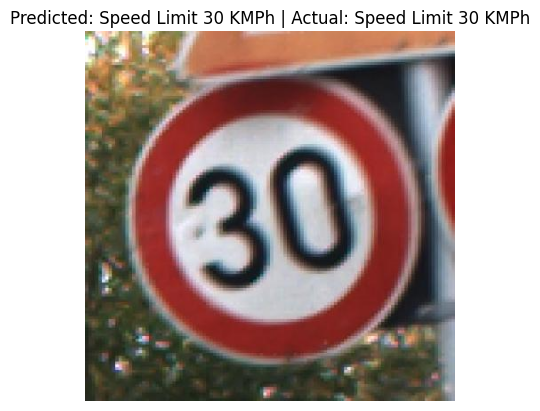

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


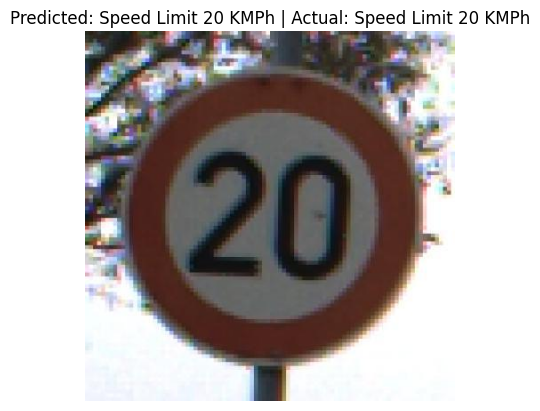

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


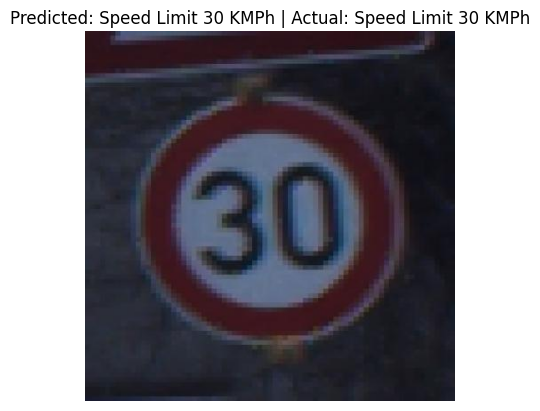

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


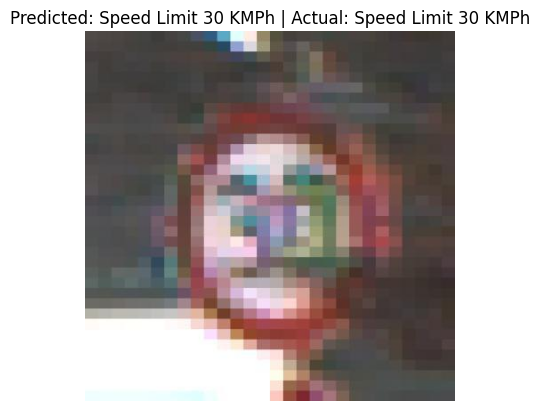

Testing completed.


In [49]:
import os
import random
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model_path = "CUSTOMCNNMODELJOSH.h5"
model = load_model(model_path)

# Class labels
classes = [
    "Road narrows on right","50 mph speed limit","Attention Please",
    "Beware of children","CYCLE ROUTE AHEAD WARNING", "Dangerous Left Curve Ahead", "Dangerous Right Curve Ahead",
    "End of all speed and passing limits", "Give Way","Go Straight or Turn Right","Go straight or turn left",
    "Keep-Left","Keep-Right","Left Zig Zag Traffic","No Entry","No_Over_Taking",
    "Overtaking by trucks is prohibited", "Pedestrian Crossing","Round-About","Slippery Road Ahead",
    "Speed Limit 20 KMPh","Speed Limit 30 KMPh","Stop_Sign", "Straight Ahead Only","Traffic_signal",
    "Truck traffic is prohibited", "Turn left ahead","Turn right ahead","Uneven Road"
]

def preprocess_image(image, target_size=(64, 64)):
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

def display_image_with_predictions(image, predicted_class, ground_truth_class):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class} | Actual: {ground_truth_class}")
    plt.axis('off')
    plt.show()

def test_on_multiple_images_with_matplotlib(test_images_path, test_labels_path, num_samples=5):
    image_files = os.listdir(test_images_path)
    random.shuffle(image_files)
    selected_files = image_files[:num_samples]

    for file in selected_files:
        img_path = os.path.join(test_images_path, file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Unable to load image {img_path}")
            continue

        input_image = preprocess_image(image)
        predictions = model.predict(input_image)
        predicted_class_index = np.argmax(predictions)
        predicted_class = classes[predicted_class_index]

        label_file = file.replace(".jpg", ".txt").replace(".png", ".txt")
        label_path = os.path.join(test_labels_path, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if lines:
                ground_truth_index = int(lines[0].split()[0])
                ground_truth_class = classes[ground_truth_index]
            else:
                ground_truth_class = "Unknown"

        display_image_with_predictions(image, predicted_class, ground_truth_class)

    print("Testing completed.")

# Paths
test_images_path = "Traffic-and-Road-Signs-1/test/images"
test_labels_path = "Traffic-and-Road-Signs-1/test/labels"

# Test the function
test_on_multiple_images_with_matplotlib(test_images_path, test_labels_path, num_samples=30)


# custom cnn model

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

############################
# 1. Simple CNN
############################
def create_simple_cnn_model(input_shape, num_classes):
    simple_cnn = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    simple_cnn.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return simple_cnn
input_shape = (64, 64, 3)
num_classes = 29
model_simple_cnn = create_simple_cnn_model(input_shape, num_classes)
model_simple_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.4801 - loss: 1.8894 - val_accuracy: 0.9355 - val_loss: 0.3003
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9565 - loss: 0.2072 - val_accuracy: 0.9630 - val_loss: 0.1866
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9738 - loss: 0.1082 - val_accuracy: 0.9745 - val_loss: 0.1180
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9918 - loss: 0.0393 - val_accuracy: 0.9565 - val_loss: 0.1685
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9930 - loss: 0.0247 - val_accuracy: 0.9780 - val_loss: 0.1311
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9960 - loss: 0.0327 - val_accuracy: 0.9835 - val_loss: 0.1122
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9825 - val_loss: 0.1203
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 1.0000 - loss: 8.8365e-04 - val

# Vgg model 

In [44]:
############################
# 2. VGG-like Model
############################
def create_vgg_like_model(input_shape, num_classes):
    vgg_like = models.Sequential([
        layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    vgg_like.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return vgg_like

input_shape = (64, 64, 3)
num_classes = 29
model_vgg_like = create_vgg_like_model(input_shape, num_classes)

model_vgg_like.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))



Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 257ms/step - accuracy: 0.1652 - loss: 2.8634 - val_accuracy: 0.5560 - val_loss: 1.2648
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 206s 825ms/step - accuracy: 0.5955 - loss: 1.1990 - val_accuracy: 0.9335 - val_loss: 0.2358
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 870ms/step - accuracy: 0.8910 - loss: 0.3350 - val_accuracy: 0.9840 - val_loss: 0.0776
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 262s 872ms/step - accuracy: 0.9617 - loss: 0.1344 - val_accuracy: 0.9810 - val_loss: 0.0812
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 881ms/step - accuracy: 0.9710 - loss: 0.0959 - val_accuracy: 0.9855 - val_loss: 0.0457
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 119s 475ms/step - accuracy: 0.9737 - loss: 0.0889 - val_accuracy: 0.9885 - val_loss: 0.0549
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.9773 - loss: 0.0732 - val_accuracy: 0.9910 - val_loss: 0.0319
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 266ms/step - accuracy: 0.9857 - lo

# Lenet Model

In [45]:

############################
# 4. LeNet-Style Model
############################
def create_lenet_model(input_shape, num_classes):
    lenet = models.Sequential([
        layers.Conv2D(6, (5,5), activation='relu', input_shape=input_shape),
        layers.AveragePooling2D((2,2)),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.AveragePooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    lenet.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return lenet
input_shape = (64, 64, 3)
num_classes = 29
model_lenet = create_lenet_model(input_shape, num_classes)
model_lenet.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3679 - loss: 2.2778 - val_accuracy: 0.8410 - val_loss: 0.6003
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8887 - loss: 0.4275 - val_accuracy: 0.9350 - val_loss: 0.2871
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9556 - loss: 0.1758 - val_accuracy: 0.9465 - val_loss: 0.2436
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9704 - loss: 0.1082 - val_accuracy: 0.9575 - val_loss: 0.2058
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9800 - loss: 0.0882 - val_accuracy: 0.9675 - val_loss: 0.1884
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9813 - loss: 0.0719 - val_accuracy: 0.9625 - val_loss: 0.1891
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9861 - loss: 0.0575 - val_accuracy: 0.9550 - val_loss: 0.2067
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9889 - loss: 0.0514 - val_accuracy

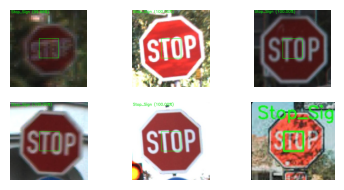

In [54]:
from PIL import Image
import matplotlib.pyplot as plt

# List of image file paths
image_paths = ['i1.png', 'i2.png', 'i3.png', 
               'i4.png', 'i5.png', 'i6.png']

# Open images using Pillow
images = [Image.open(image_path) for image_path in image_paths]

# Set up a matplotlib figure and axes with a smaller size
fig, axs = plt.subplots(2, 3, figsize=(4, 2))  # Smaller figsize for a smaller output

# Iterate over the images and axes to plot them
for ax, img in zip(axs.ravel(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes ticks and labels

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined image with a smaller size
plt.savefig('combined_output_small.png', bbox_inches='tight', dpi=200)
plt.show()
